#### Load the required dependencies

In [1]:
%pylab inline
import xarray as xr
from tqdm import tqdm_notebook
import cmocean.cm as cmo
import pandas as pd

plt.rcParams['figure.figsize'] = (18,10)
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.direction'] = 'out'

font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 16}

matplotlib.rc('font', **font)

rc('ytick.major', size=6)
rc('xtick.major', size=6)
rc('ytick.minor', size=4)
rc('xtick.minor', size=4)
rc('lines', linewidth=2.5)

Populating the interactive namespace from numpy and matplotlib


In [35]:
# seaice = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/seaice/AMSR2_daily/asi*.hdf', 
#                           concat_dim=pd.date_range(start='2018-01-01', end='2019-03-31', freq='D'))

seaice = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/seaice/AMSR2_daily/asi*.hdf',
                            concat_dim='time', combine='nested')

seaice_lnlt = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/seaice/AMSR2_daily/LongitudeLatitudeGrid-s6250-Antarctic.hdf')

In [36]:
seaice['time'] = (('time'), pd.date_range(start='2018-01-01', end='2019-03-31', freq='D'))

In [37]:
seaice = seaice.rename({'ASI Ice Concentration': 'si_conc'})
seaice = seaice.assign_coords(lon=(["x", "y"], np.array(seaice_lnlt.Longitudes)))
seaice = seaice.assign_coords(lat=(["x", "y"], np.array(seaice_lnlt.Latitudes)))
seaice = seaice.assign(si=(["time", "x", "y"], seaice.si_conc.values))
seaice = seaice.drop('si_conc')

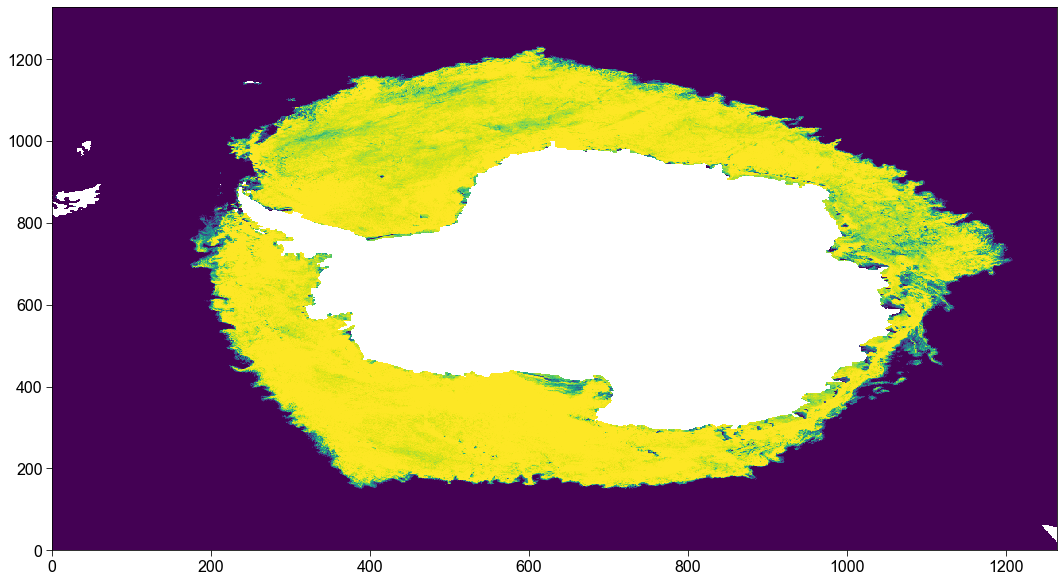

In [44]:
pcolormesh(seaice.si.sel(time='2018-07-30'))

In [7]:
seaice_mnth = seaice.resample(time='1M').mean()

/Users/marcel/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [88]:
# seaice_subset = seaice.sel(time=slice('2018-12-05', '2018-12-15'))

Interpolation

In [110]:
seaice_subset = seaice.sel(time=slice('2018-07-01', '2019-03-31'))

In [111]:
from scipy.interpolate import griddata as g
from tqdm import tqdm

X = np.arange(-180, 180.1, 0.1)
Y = np.arange(-70, -49.9, 0.1)

x, y = np.meshgrid(X,Y)

sic_new = np.ndarray([len(seaice_subset.si), len(Y), len(X)])

x_, y_ = np.ravel(seaice_subset.lon), np.ravel(seaice_subset.lat)
x_[x_>180] = x_[x_>180]-360

for i in tqdm(range(len(seaice_subset.si))):
 
    si = np.ravel(seaice_subset.si[i, :, :].values)
    sic_new[i, :, :] = g((y_, x_), si, (y, x), method='nearest')
       
sic_new[sic_new==0] = np.NaN
sic_new = np.ma.masked_invalid(sic_new)


100%|██████████| 274/274 [08:14<00:00,  1.81s/it]


In [112]:
sic = xr.Dataset(data_vars={'sic' : (('time', 'lat', 'lon'), sic_new)},
                 coords={'time' : seaice_subset.time, 
                         'lat'  : Y, 
                         'lon'  : X})

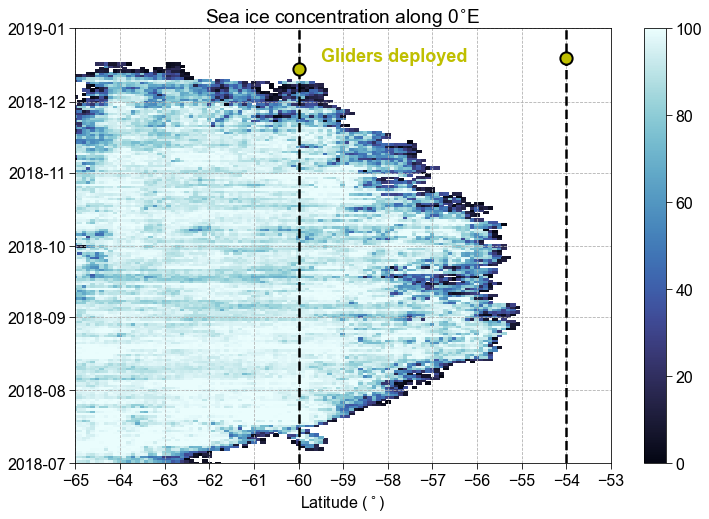

In [154]:
fig,ax=subplots(figsize=[12, 8])

ds=sic.sic.isel(lon=1800)
ds.plot(cmap=cmo.ice, ax=ax, vmin=0, vmax=100, cbar_kwargs={'label': ''})
ax.set_xlim(-65, -53)
ax.set_title('Sea ice concentration along 0$^{\circ}$E')
ax.grid(ls='--')
ax.plot(np.zeros(len(ds.time))-60, ds.time, c='k', ls='--')
ax.plot(np.zeros(len(ds.time))-54, ds.time, c='k', ls='--')
ax.xaxis.set_ticks(np.arange(-65, -52, 1))

ax.set_xlabel('Latitude ($^\circ$)')
ax.set_ylabel('')

ax.set_ylim('2018-07-01', '2019-01-01')

scatter(-54, pd.to_datetime('2018-12-19T16:09:34'), s=150, marker='o', facecolor='y', edgecolor='k', lw=2, zorder=10)
scatter(-60, pd.to_datetime('2018-12-14T21:56:37'), s=150, marker='o', facecolor='y', edgecolor='k', lw=2, zorder=10)

ax.text(-59.5, pd.to_datetime('2018-12-18'), 'Gliders deployed', c='y', fontsize=18, fontweight='bold')

savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/figS1_seaice_hov.png', dpi=300, bbox_inches='tight')

In [163]:
sic.lon[1800]

<xarray.DataArray 'lon' ()>
array(-1.02318154e-11)
Coordinates:
    lon      float64 -1.023e-11

In [175]:
ds = sic.sic.sel(time='2018-09-05', lon=sic.lon[1800])
ds = ds.where(ds>0, drop=True)

In [182]:
import gsw
gsw.distance([0, -0.008145], [ds.lat.max(), -59.83])/1000
gsw.distance([0, -0.00884], [ds.lat.max(), -53.96])/1000

array([126.76349937])

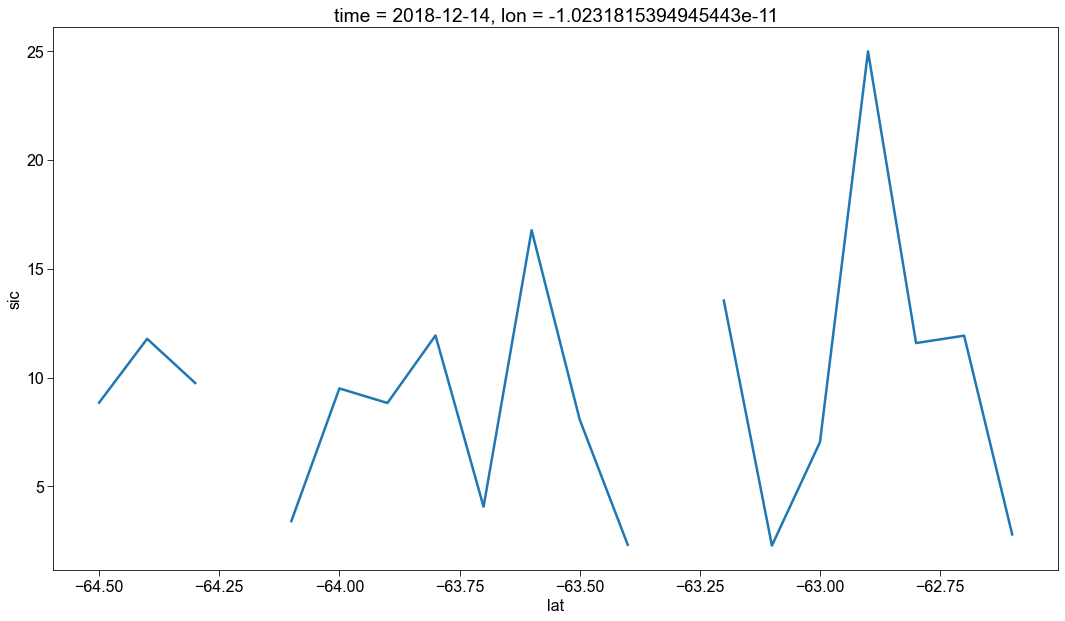

In [207]:
ds = sic.sic.sel(time='2018-12-14', lon=sic.lon[1800]).plot()

In [206]:
ds

<xarray.DataArray 'sic' ()>
array(78.53439331)
Coordinates:
    time     datetime64[ns] 2018-12-09
    lat      float64 -60.0
    lon      float64 -1.023e-11

In [152]:
sic.to_netcdf('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/seaice/sic_interp.nc')

#### Start here to open the interpolated sea ice data files

In [8]:
sic = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/sic_mnth_interp.nc')

Load absolute dynamic topography

In [153]:
adt = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/adt/nrt*.nc')

adt_lon  = np.concatenate([adt.longitude.values[180:]-360, adt.longitude.values[:180]])
adt_lat  = adt.latitude.values
adt_time = adt.time.values

ugeo = np.concatenate([adt.ugos[:, :, 180:], adt.ugos[:, :, :180]], axis=2) # units of mm/s
vgeo = np.concatenate([adt.vgos[:, :, 180:], adt.vgos[:, :, :180]], axis=2) # units of mm/s
adt  = np.concatenate([adt.adt[:, :, 180:], adt.adt[:, :, :180]], axis=2) 

geo = xr.Dataset(data_vars={'vgeo': (('time', 'lat', 'lon'), vgeo),
                            'ugeo': (('time', 'lat', 'lon'), ugeo),
                            'adt' : (('time', 'lat', 'lon'), adt)},
                 coords={'time' : adt_time, 
                         'lat'  : adt_lat, 
                         'lon'  : adt_lon})

In [82]:
etopo = xr.open_dataset('/Users/marcel/Downloads/ETOPO1_Ice_g_gmt4.grd')

Sea ice map plotting

In [10]:
adt_mean = geo.adt.mean(dim='time')

/Users/marcel/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [11]:
adt_mean = adt_mean.sel(lon=slice(-40, 40))

In [87]:
from __future__ import division # to remove integer division (e.g. 2/5=0)
from __future__ import unicode_literals # to remove unicode/ascii distinction in python2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as spio
import matplotlib

# Use custom colormap function from Earle
def custom_div_cmap(numcolors=11, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with three colors
    
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap 
    
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap

# make negative contours, normally dashed by default, be solid
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

In [91]:
blevels = [-8000, -7000, -6000, -5000, -4000, -3000, -2000, -1500, -1000, -500, -200, -100, 0]
N = len(blevels)-1
cmap2 = custom_div_cmap(N, mincol='DarkBlue', midcol='CornflowerBlue' ,maxcol='w')
cmap2.set_over('0.85') # set positive values (land) as light gray

In [141]:
cmp_gray = cm.gray
cmp_gray.set_over('0.85')

blevels = [-8000, -7000, -6000, -5000, -4000, -3000, -2000, -1500, -1000, -500, -200, -100, 0]


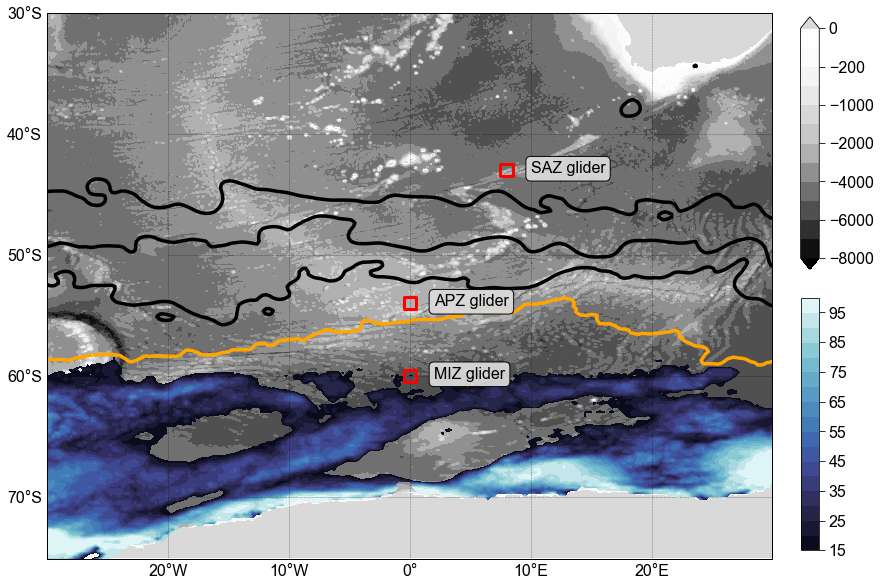

In [148]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig = figure(figsize=[13, 13])

proj = ccrs.PlateCarree()

ax = plt.axes(projection = proj)
# ax.coastlines('50m')

h_et = ax.contourf(etopo.x, etopo.y, etopo.z, vmin=-8000, vmax=0, levels=blevels, cmap=cmp_gray, extend='both', transform = ccrs.PlateCarree())
# ax.contour(etopo.x, etopo.y, etopo.z, levels=blevels, colors='0.85', transform = ccrs.PlateCarree(), alpha=0.1)

h_si = ax.contourf(sic.lon, sic.lat, sic.sic[11], levels=np.arange(15, 105, 5), cmap=cmo.ice, transform = ccrs.PlateCarree())
h_fr = ax.contour(adt_mean.lon, adt_mean.lat, adt_mean, levels=[-0.943, -0.48, 0.03], colors='k', linewidths=3.5, linestyles='-', transform = ccrs.PlateCarree())
h_im = ax.contour(sic.lon, sic.lat, sic.sic[8], levels=[15], colors='orange', transform = ccrs.PlateCarree(), linewidths=3.5)
# ax.contour(sic.lon, sic.lat, sic.sic[11], levels=[15], colors='orange', transform = ccrs.PlateCarree(), linewidths=3, linestyles='--')

extent = [-30, 30, -73, -29.99]
ax.set_extent(extent)

gl=ax.gridlines(xlocs=np.arange(-20,40,10), 
                ylocs=np.arange(-90, 0,10), 
                linestyle='--', color='k', linewidth=0.5, alpha=0.5,
                draw_labels=True,
                crs=ccrs.PlateCarree(), )

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False

cax = fig.add_axes([0.93, 0.52, 0.02, 0.27])
cbar = colorbar(h_et, cax=cax)

cax = fig.add_axes([0.93, 0.22, 0.02, 0.27])
cbar = colorbar(h_si, cax=cax)

ax.scatter([0, 0, 8], [-60, -54, -43], s=150, marker='s', facecolor='none', edgecolor='red', transform = ccrs.PlateCarree(), zorder=100, linewidth=3)

props = dict(boxstyle='round', facecolor='0.85', alpha=0.95)

# place a text box in upper left in axes coords
ax.text(10, -43.5, 'SAZ glider', fontsize=16, verticalalignment='bottom', bbox=props, transform = ccrs.PlateCarree())
ax.text( 2, -54.5, 'APZ glider', fontsize=16, verticalalignment='bottom', bbox=props, transform = ccrs.PlateCarree())
ax.text( 2, -60.5, 'MIZ glider', fontsize=16, verticalalignment='bottom', bbox=props, transform = ccrs.PlateCarree())

savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig1_map.png', dpi=300, bbox_inches='tight')

Calculate EKE

In [24]:
vel = np.sqrt(geo.ugeo**2 + geo.vgeo**2)
eke = np.abs(np.nanmean(vel) - vel)

In [25]:
mean_eke = np.mean(eke, axis=0)

mean_ugeo = np.nanmean(geo.ugeo, axis=0)
mean_vgeo = np.nanmean(geo.vgeo, axis=0)

In [115]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

/Users/marcel/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


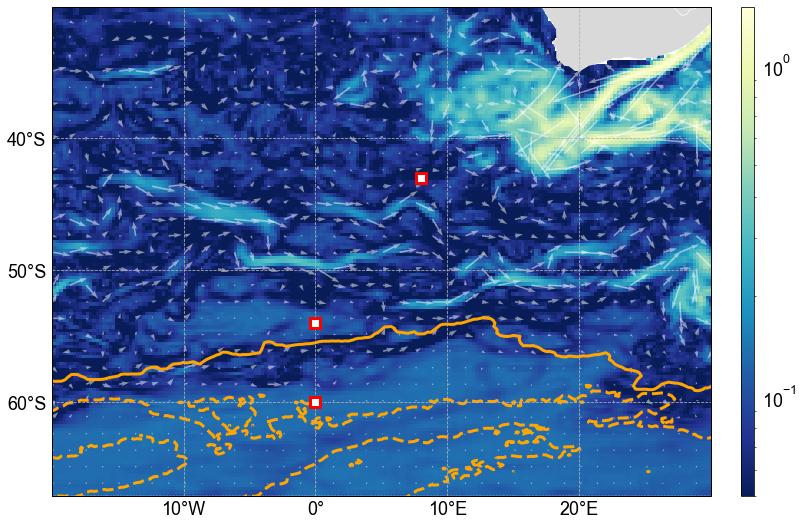

In [136]:
fig = plt.Figure()
fig.set_canvas(plt.gcf().canvas)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, linewidth=0.5, edgecolor='white')

im = ax.pcolormesh(geo.lon, geo.lat, mean_eke, cmap='YlGnBu_r', 
              norm=colors.LogNorm(vmin=0.5e-1, vmax=1.5),
              transform = ccrs.PlateCarree())

plt.colorbar(mappable=im, ax=ax, aspect=40, pad=0.03)

gl=ax.gridlines(linestyle='--', draw_labels=True)
gl.xlocator = mticker.FixedLocator(np.arange(-20, 40, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-70, -20, 10))
gl.xlabels_top = False; gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER

ax.set_extent([-20, 30, -65, -30])

i=5

ax.quiver(geo.lon[::i], geo.lat[::i], mean_ugeo[::i, ::i], mean_vgeo[::i, ::i], 
          transform = ccrs.PlateCarree(), color='w', alpha=0.5)

# ax.pcolormesh(sic.lon, sic.lat, sic.sic[8], cmap=cmo.ice, transform = ccrs.PlateCarree())
ax.contour(sic.lon, sic.lat, sic.sic[8], levels=[15], colors='orange', transform = ccrs.PlateCarree(), linewidths=3)
ax.contour(sic.lon, sic.lat, sic.sic[11], levels=[15], colors='orange', linestyles='--', transform = ccrs.PlateCarree(), linewidths=3)

plt.plot([0, 0, 8], [-60, -54, -43], '-s', color='k',
         markersize=10, linewidth=0,
         markerfacecolor='white',
         markeredgecolor='r',
         markeredgewidth=3, transform=ccrs.PlateCarree())

# countries and coastlines
shpf = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')

reader = shpreader.Reader(shpf)
countries = reader.records()

for country in countries:
    ax.add_geometries(country.geometry, ccrs.PlateCarree(), facecolor='0.85', linewidth=0.5, edgecolor='white')

In [152]:
adt_mean = adt_mean.sel(lat=slice(-80, -30))

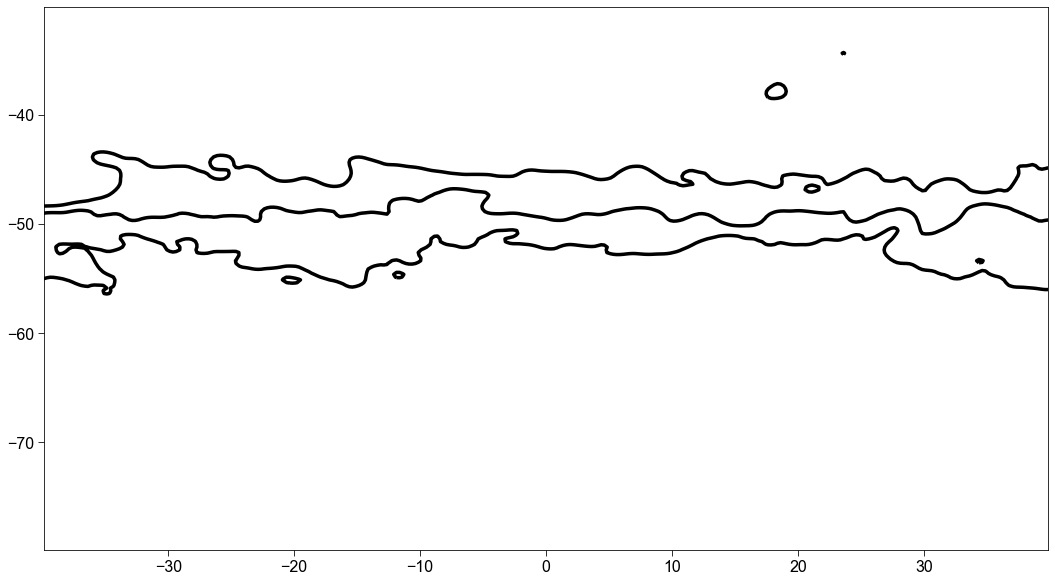

In [172]:
saf = 0.03
pf = -0.48
saccf = -0.943

cs=contour(adt_mean.lon, adt_mean.lat, adt_mean, levels=[-0.943, -0.48, 0.03], colors='k', linewidths=3.5, linestyles='-')

dat = cs.allsegs

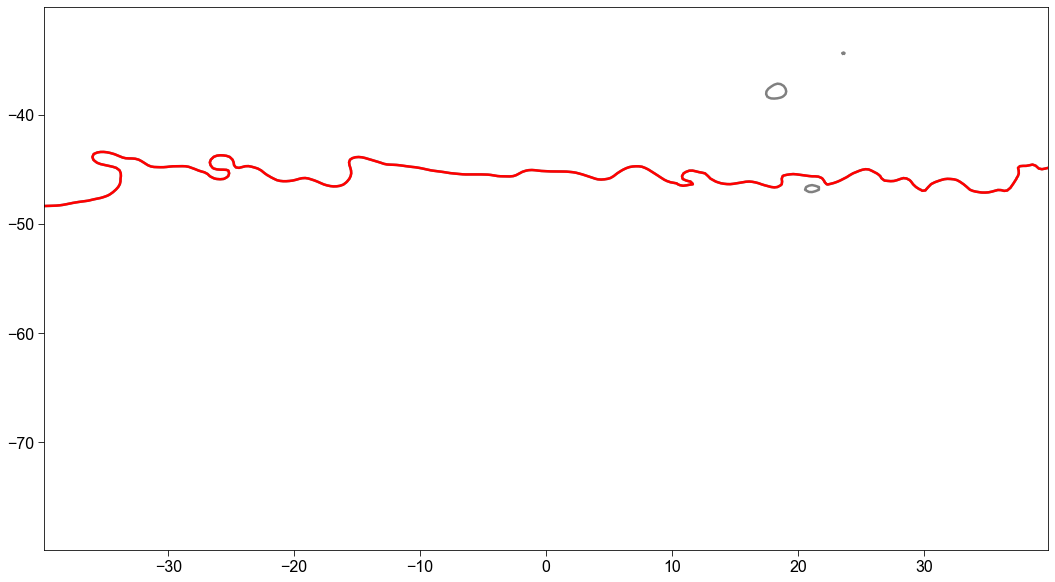

In [201]:
CS = contour(adt_mean.lon, adt_mean.lat, adt_mean, levels=[0.03], colors='0.5')
dat0 = CS.allsegs[0][0]
plt.plot(dat0[:,0],dat0[:,1], c='r')
saf = dat0

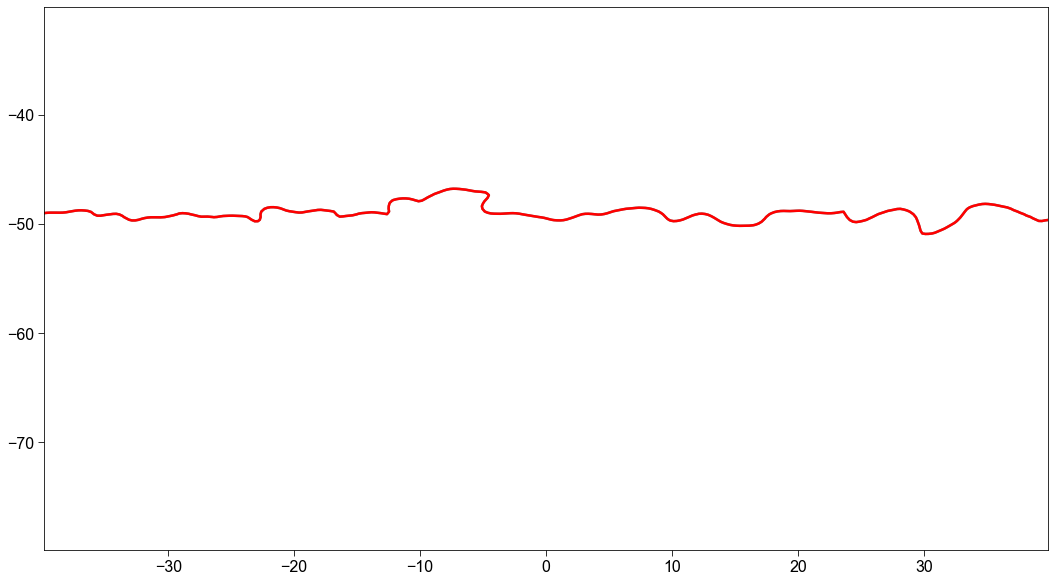

In [202]:
CS = contour(adt_mean.lon, adt_mean.lat, adt_mean, levels=[-0.48], colors='0.5')
dat0 = CS.allsegs[0][0]
plt.plot(dat0[:,0],dat0[:,1], c='r')
pf = dat0

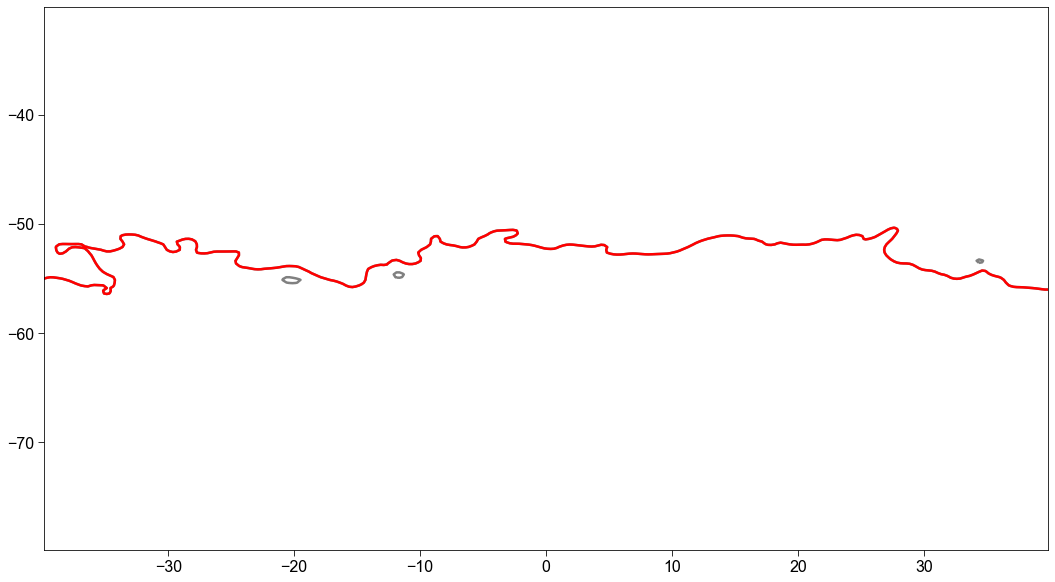

In [216]:
CS = contour(adt_mean.lon, adt_mean.lat, adt_mean, levels=[-0.943], colors='0.5')
dat0 = CS.allsegs[0][0]
plt.plot(dat0[:,0],dat0[:,1], c='r')
saccf = dat0

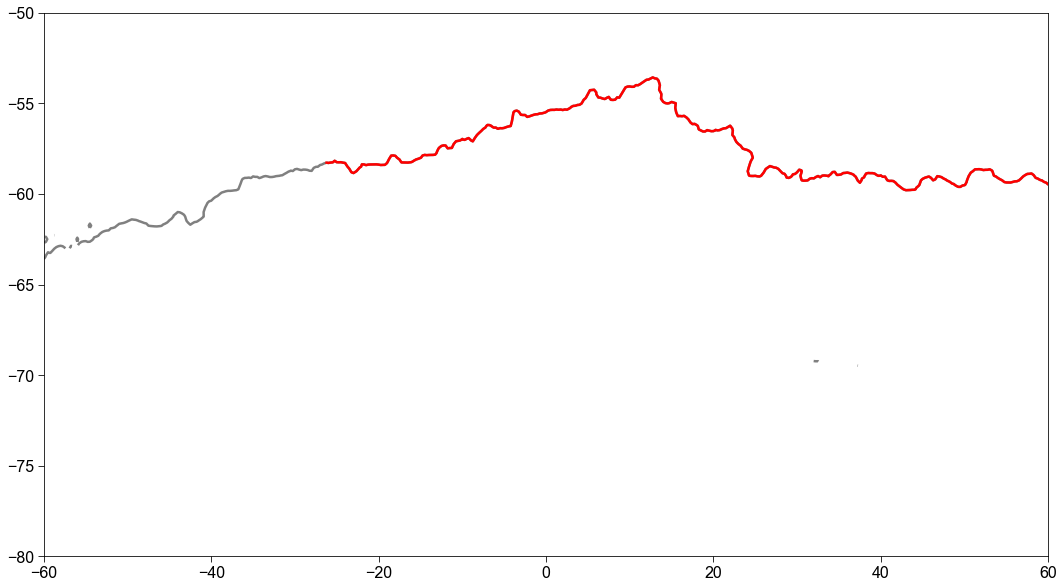

In [217]:
CS=contour(sic.lon, sic.lat, sic.sic[8], levels=[15], colors='0.5')
dat0 = CS.allsegs[0][6]
plt.plot(dat0[:,0],dat0[:,1], c='r')
si = dat0

In [218]:
def find_lat(data, lon_tgt=0):
    
    lon = data[:, 0]
    lat = data[:, 1]
    
    i_ln = np.argmin(np.abs(lon-lon_tgt))
    
    print(lat[i_ln])
    
    return 

In [219]:
find_lat(saf  , lon_tgt=8)
find_lat(pf   , lon_tgt=0)
find_lat(saccf, lon_tgt=0)
find_lat(si, lon_tgt=0)

-44.884216763696266
-49.45719402344346
-52.24401926823988
-55.479244435766056
